將每個Tool最後一次RUL=0之後的資料都刪掉

In [708]:
# Step 1: 匯入套件
import pandas as pd
import numpy as np

# Step 2: 讀取 CSV
df = pd.read_csv("./csv/dataset.csv", parse_dates=["DateTime"])

print("原始資料筆數:", len(df))
df
df['FP3'] = df['FPD']
df = df[['FP3','FPD','DateTime', 'Tool']]


原始資料筆數: 334


In [709]:
# i want to add new features called RUL when FPD >0.5 then RUL = 0, else -1
df['RUL'] = np.where(df['FPD'] > 0.5, 0, -1)
df

,FP3,FPD,DateTime,Tool,RUL
0,0.69,0.69,2022-01-01,A,0
1,0.56,0.56,2022-01-07,A,0
2,0.71,0.71,2022-01-26,A,0
3,0.80,0.80,2022-02-14,A,0
4,0.82,0.82,2022-03-02,A,0
...,...,...,...,...,...
329,0.79,0.79,2024-11-25,E,0
330,0.78,0.78,2024-12-04,E,0
331,0.46,0.46,2024-12-09,E,-1
332,0.56,0.56,2024-12-16,E,0


In [710]:
# i want to drop FPD column
df = df.drop(columns=['FPD'])
df

,FP3,DateTime,Tool,RUL
0,0.69,2022-01-01,A,0
1,0.56,2022-01-07,A,0
2,0.71,2022-01-26,A,0
3,0.80,2022-02-14,A,0
4,0.82,2022-03-02,A,0
...,...,...,...,...
329,0.79,2024-11-25,E,0
330,0.78,2024-12-04,E,0
331,0.46,2024-12-09,E,-1
332,0.56,2024-12-16,E,0


In [711]:
# i want to divide this df based on tool sort it with DateTime
df = df.sort_values(by='DateTime')
# I want to save each diffrenct Tool as new df and save it to dict
tool_dfs = {tool: df[df["Tool"] == tool] for tool in df["Tool"].unique()}
# set DateTime as index and drop the Tool column
for tool in tool_dfs:
    tool_dfs[tool] = tool_dfs[tool].set_index('DateTime')
    tool_dfs[tool] = tool_dfs[tool].drop(columns=['Tool'])
    tool_dfs[tool].index = tool_dfs[tool].index.strftime('%Y-%m-%d') 
    # 轉換成 DateTime 格式
    tool_dfs[tool].index = pd.to_datetime(tool_dfs[tool].index)

In [712]:
def trim_df_at_last_zero(df, col="RUL"):
    # 找到所有 0 的索引
    zero_indices = df.index[df[col] == 0].tolist()
    if not zero_indices:
        # 沒有 0 → 回傳空的 DataFrame（保留相同欄位結構）
        return df.iloc[0:0]
    
    # 找到最後一個 0 的索引
    last_zero_idx = zero_indices[-1]
    
    # 保留從開頭到最後一個 0 的資料
    new_df = df.loc[:last_zero_idx]
    return new_df

for tool in tool_dfs:
    tool_dfs[tool] = trim_df_at_last_zero(tool_dfs[tool])

# print last row of each tool df
for tool in tool_dfs:
    print(f"Last row of {tool} df:")
    print(tool_dfs[tool].iloc[-1])

Last row of A df:
FP3    0.62
RUL    0.00
Name: 2024-12-16 00:00:00, dtype: float64
Last row of C df:
FP3    0.67
RUL    0.00
Name: 2024-12-31 00:00:00, dtype: float64
Last row of E df:
FP3    0.66
RUL    0.00
Name: 2024-12-30 00:00:00, dtype: float64
Last row of B df:
FP3    0.77
RUL    0.00
Name: 2024-12-12 00:00:00, dtype: float64
Last row of D df:
FP3    0.8
RUL    0.0
Name: 2024-12-15 00:00:00, dtype: float64


In [713]:
import pandas as pd

def interpolate_daily_with_rul(df: pd.DataFrame, rul_col: str = "RUL") -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame 的 index 必須是 DatetimeIndex。")

    # 確保 index 排序
    df = df.sort_index()

    # 建立完整每日 index
    full_range = pd.date_range(df.index.min().normalize(), df.index.max().normalize(), freq="D")

    # 分開 RUL 和其他欄位
    other_cols = [c for c in df.columns if c != rul_col]

    # 先處理其他欄位：線性差值 + ffill/bfill
    out = df[other_cols].reindex(full_range)
    if len(other_cols) > 0:
        out = out.interpolate(method="time", limit_direction="both")
        out = out.bfill().ffill()

    # 特別處理 RUL 欄位
    rul = df[[rul_col]].reindex(full_range)

    # 翻轉
    rul_rev = rul[::-1].copy()

    # 從上往下填
    for i in range(1, len(rul_rev)):
        prev_val = rul_rev.iloc[i-1, 0]
        if pd.notna(prev_val):  # 有前值
            if rul_rev.iloc[i, 0] != 0:  # 不是 0 → 強制前一個值 + 1
                rul_rev.iloc[i, 0] = prev_val + 1

    # 翻回來
    rul_final = rul_rev[::-1]

    # 合併
    out[rul_col] = rul_final
    return out

for tool in tool_dfs:
    tool_dfs[tool] = interpolate_daily_with_rul(tool_dfs[tool])


In [714]:
SLIDE_WINDOW = 31 # X+y

def create_sliding_window_features(df: pd.DataFrame, window_size: int = SLIDE_WINDOW) -> list:
    """
    將 DataFrame 切成滑動視窗序列
    :param df: 原始 DataFrame，index 順序很重要
    :param window_size: 視窗大小
    :return: list，每個元素是一個 DataFrame (長度 = window_size)
    """
    windows = []
    for start in range(0, len(df) - window_size + 1):
        end = start + window_size
        window = df.iloc[start:end].copy()
        windows.append(window)
    return windows


tool_dfs_sliding = {}
for tool in tool_dfs:
    tool_dfs_sliding[tool] = create_sliding_window_features(tool_dfs[tool])

#
for tool in tool_dfs_sliding:
    print(f"Tool: {tool}, Number of Windows: {len(tool_dfs_sliding[tool])}")

Tool: A, Number of Windows: 1051
Tool: C, Number of Windows: 1066
Tool: E, Number of Windows: 1065
Tool: B, Number of Windows: 1047
Tool: D, Number of Windows: 1050


In [715]:
TRAIN_TEST_SPLIT = 0.8

def split_train_test(tool_dfs_sliding: dict, split_ratio: float = TRAIN_TEST_SPLIT) -> dict:
    train_test_split = {}
    for tool, windows in tool_dfs_sliding.items():
        split_index = int(len(windows) * split_ratio)
        train_test_split[tool] = {
            "train": windows[:split_index],
            "test": windows[split_index:]
        }
    return train_test_split

tool_dfs_train_test = split_train_test(tool_dfs_sliding)


for tool, splits in tool_dfs_train_test.items():
    print(f"Tool: {tool}, Train Windows: {len(splits['train'])}, Test Windows: {len(splits['test'])}")


Tool: A, Train Windows: 840, Test Windows: 211
Tool: C, Train Windows: 852, Test Windows: 214
Tool: E, Train Windows: 852, Test Windows: 213
Tool: B, Train Windows: 837, Test Windows: 210
Tool: D, Train Windows: 840, Test Windows: 210


In [716]:
import random
def shuffle_windows(windows: list) -> list:
    """
    Shuffle a list of DataFrames.
    :param windows: list of DataFrames
    :return: shuffled list of DataFrames
    """
    return random.sample(windows, len(windows))

# Shuffle train as train_shuffled
for tool in tool_dfs_train_test:
    train_windows = tool_dfs_train_test[tool]["train"]
    tool_dfs_train_test[tool]["train_shuffled"] = shuffle_windows(train_windows)

for tool, splits in tool_dfs_train_test.items():
    print(f"Tool: {tool}, Train Shuffled Windows: {len(splits['train_shuffled'])}, Test Windows: {len(splits['test'])}")

Tool: A, Train Shuffled Windows: 840, Test Windows: 211
Tool: C, Train Shuffled Windows: 852, Test Windows: 214
Tool: E, Train Shuffled Windows: 852, Test Windows: 213
Tool: B, Train Shuffled Windows: 837, Test Windows: 210
Tool: D, Train Shuffled Windows: 840, Test Windows: 210


In [717]:
# Merge All Train Shuffle as list
train_shuffled_merged = []
for tool in tool_dfs_train_test:
    train_shuffled_merged.extend(tool_dfs_train_test[tool]["train_shuffled"])

test_merged = []
for tool in tool_dfs_train_test:
    test_merged.extend(tool_dfs_train_test[tool]["test"])

# SPLIT AS Y (RUL) AND X (All columns except RUL)

X_train_list = []
Y_train_list = []
for obj in train_shuffled_merged:
    X_train_list.append(obj.drop(columns=["RUL"]).iloc[:-1]) # drop是拿掉RUL欄位 iloc是拿掉天數（第31行）
    Y_train_list.append(obj["RUL"].iloc[-1]) # 只取RUL欄位 並每個window只取最後一天（第31天）

X_test_list=[]
Y_test_list=[]

for obj in test_merged:
    X_test_list.append(obj.drop(columns=["RUL"]).iloc[:-1])
    Y_test_list.append(obj["RUL"].iloc[-1])

In [718]:
import torch
# Convert to PyTorch tensors but ValueError: could not determine the shape of object type 'DataFrame'
# so transform the DataFrames to numpy arrays first

X_train_list = [x.to_numpy() for x in X_train_list]
Y_train_list = np.array(Y_train_list)   # 不需要用 to_numpy

X_train_tensor = torch.tensor(X_train_list, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train_list, dtype=torch.float32)

X_test_list = [x.to_numpy() for x in X_test_list]
Y_test_array = np.array(Y_test_list)

X_test_tensor = torch.tensor(X_test_list, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test_array, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [719]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備：{device}')

使用設備：cpu


In [720]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, batch_first=False):
        super(PositionalEncoding, self).__init__()
        self.batch_first = batch_first

        # 建立位置編碼矩陣 (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數維
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數維

        # 如果 batch_first=False → (max_len, 1, d_model)
        # 如果 batch_first=True → (1, max_len, d_model)
        if batch_first:
            pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        else:
            pe = pe.unsqueeze(1)  # (max_len, 1, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        if self.batch_first:
            # x shape: (batch, seq_len, d_model)
            x = x + self.pe[:, :x.size(1), :]
        else:
            # x shape: (seq_len, batch, d_model)
            x = x + self.pe[:x.size(0), :]
        return x

In [721]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, nhead=4, hidden_dim=128, dropout=0.01, batch_first=True):
        super(TransformerTimeSeries, self).__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim, batch_first=batch_first)  # 要確認 PositionalEncoding 也支援 batch_first
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, 
            dropout=dropout, batch_first=True  # 👈 加這個
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        # src 形狀: (batch_size, seq_length, feature_size)
        src = self.input_linear(src)
        src = self.pos_encoder(src)  # 也要改成支援 batch_first
        output = self.transformer_encoder(src)
        # 取最後一個時間步的輸出
        output = self.decoder(output[:, -1, :])  # 👈 改成 batch 在第一維
        return output


In [722]:
feature_size = X_train_tensor.size(-1)  # 輸入特徵數
print("feature_size:", feature_size)
num_layers = 4
nhead = 4
hidden_dim = 4

# model = TransformerTimeSeries(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim, batch_first=True).to(device)

feature_size: 1


In [723]:
import torch.nn as nn

class DNNTimeSeries(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.1):
        super(DNNTimeSeries, self).__init__()
        
        layers = []
        in_dim = input_dim
        for i in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        # 假設 x 的 shape = (batch, seq_len, feature_size)
        # 先攤平成 (batch, seq_len * feature_size)
        x = x.view(x.size(0), -1)
        return self.net(x)


In [724]:
input_dim = 30 * feature_size   # 把時間步展平成一個向量
hidden_dim = 256
output_dim = 1   # 例如預測下一步數值

model = DNNTimeSeries(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=3,
    dropout=0.2
).to(device)


In [725]:
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [726]:
import torch
import torch.nn as nn

# 假設你已經有這些物件：
# model, criterion, optimizer
# X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

num_epochs = 100
batch_size = 64 # 通常是16、32或 64

# 建立 DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    # ===== Training =====
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        # X_batch shape: (batch, seq_len, feature)
        # y_batch shape: (batch, pred_len) or (batch, 1)
        output = model(X_batch)  # forward pass
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    # ===== Evaluation =====
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")


Epoch [1/100] | Train Loss: 11.887500 | Test Loss: 10.365089


/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/torch/nn/modules/loss.py:1113: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/torch/nn/modules/loss.py:1113: UserWarning: Using a target size (torch.Size([61])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/torch/nn/modules/loss.py:1113: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1])).

Epoch [2/100] | Train Loss: 10.933383 | Test Loss: 10.301529
Epoch [3/100] | Train Loss: 10.933565 | Test Loss: 10.384217
Epoch [4/100] | Train Loss: 10.876232 | Test Loss: 10.555462
Epoch [5/100] | Train Loss: 10.856430 | Test Loss: 10.189962
Epoch [6/100] | Train Loss: 10.980180 | Test Loss: 10.337554
Epoch [7/100] | Train Loss: 10.876880 | Test Loss: 10.165910
Epoch [8/100] | Train Loss: 10.885508 | Test Loss: 10.117725
Epoch [9/100] | Train Loss: 10.878113 | Test Loss: 10.105087
Epoch [10/100] | Train Loss: 10.933654 | Test Loss: 10.192783
Epoch [11/100] | Train Loss: 10.970648 | Test Loss: 10.128171
Epoch [12/100] | Train Loss: 10.861854 | Test Loss: 10.188634
Epoch [13/100] | Train Loss: 10.834148 | Test Loss: 10.114932
Epoch [14/100] | Train Loss: 10.884483 | Test Loss: 10.139559
Epoch [15/100] | Train Loss: 10.873925 | Test Loss: 10.069159
Epoch [16/100] | Train Loss: 10.835443 | Test Loss: 10.065027
Epoch [17/100] | Train Loss: 10.837081 | Test Loss: 10.270205
Epoch [18/100] |

In [727]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).cpu().numpy()
    y_test_pred = model(X_test_tensor).cpu().numpy()

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:31: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:31: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:31: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:31: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:31: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366

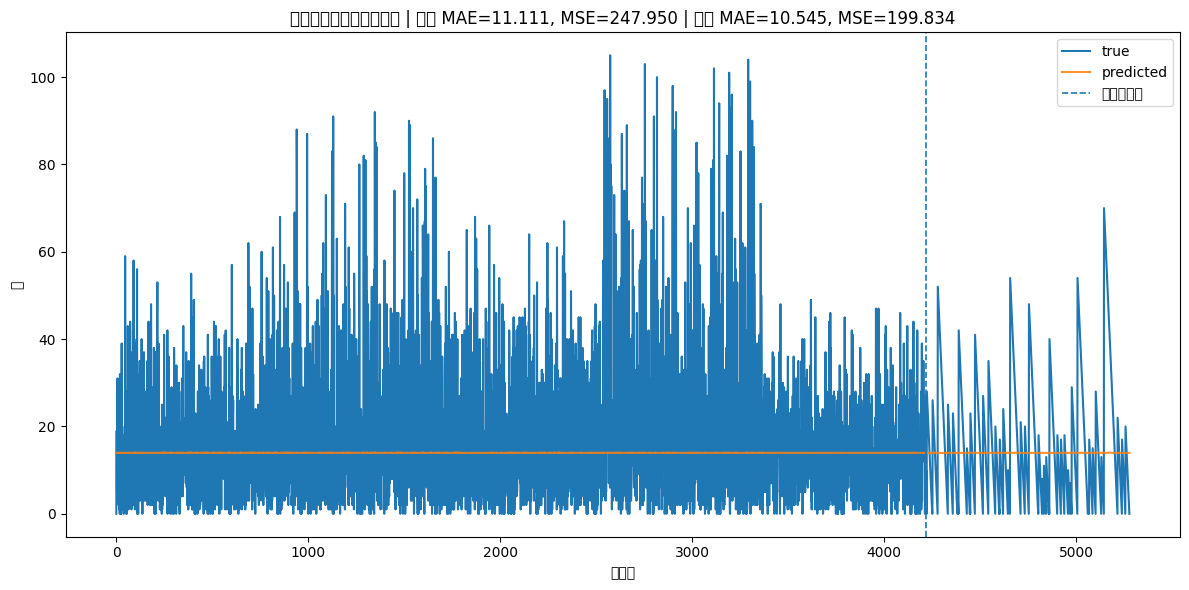

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:43: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:43: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:43: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:43: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_73011/1006984622.py:43: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2d/q366

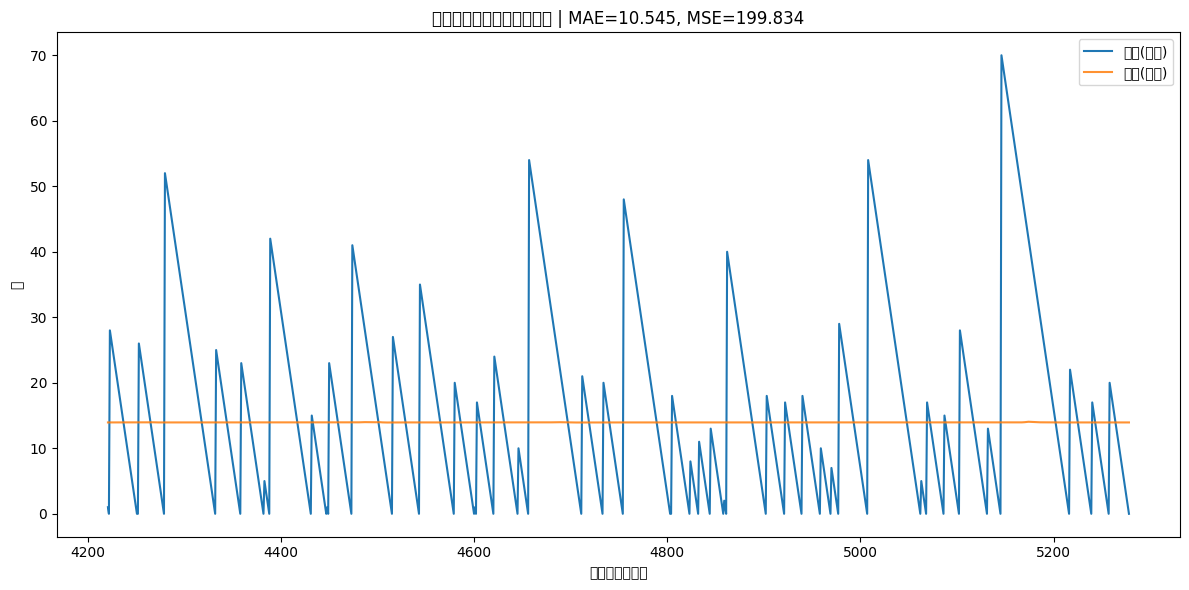

In [728]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) 拉平成一維
train_pred = y_train_pred.squeeze()
test_pred  = y_test_pred.squeeze()
train_act  = y_train_tensor.squeeze()
test_act   = y_test_tensor.squeeze()

# 2) 依「目標 y 的時間軸」拼接（注意：這裡的索引本來就對齊）
y_all_pred = np.concatenate([train_pred, test_pred], axis=0)
y_all_act  = np.concatenate([train_act,  test_act],  axis=0)
split_idx  = len(train_act)  # 測試集在整段中的起始位置

# 3) 評估指標（全段/測試段）
mae_all  = mean_absolute_error(y_all_act, y_all_pred)
mse_all = mean_squared_error(y_all_act, y_all_pred)
mae_test = mean_absolute_error(test_act, test_pred)
mse_test= mean_squared_error(test_act, test_pred)

# 4) 全區間圖（含訓練+測試）
plt.figure(figsize=(12,6))
plt.plot(y_all_act,  label='true', linewidth=1.5)
plt.plot(y_all_pred, label='predicted', alpha=0.85)
plt.axvline(split_idx-1, linestyle='--', linewidth=1.2, label='測試集開始')
plt.title(f'時間序列預測（全區間） | 全段 MAE={mae_all:.3f}, MSE={mse_all:.3f} | 測試 MAE={mae_test:.3f}, MSE={mse_test:.3f}')
plt.xlabel('時間步')
plt.ylabel('值')
plt.legend()
plt.tight_layout()
plt.show()

# 5) 測試集放大圖（更清楚看泛化）
plt.figure(figsize=(12,6))
x_test = np.arange(split_idx, len(y_all_act))
plt.plot(x_test, test_act,  label='實際(測試)', linewidth=1.5)
plt.plot(x_test, test_pred, label='預測(測試)', alpha=0.85)
plt.title(f'時間序列預測（測試區間） | MAE={mae_test:.3f}, MSE={mse_test:.3f}')
plt.xlabel('時間步（測試）')
plt.ylabel('值')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
@torch.no_grad()
def predict_tool_rul_sentence(
    model,
    df: pd.DataFrame,
    tool_name: str,
    feature_cols: list,
    seq_len: int,
    x_scaler=None,
    y_scaler=None,
    device: str = "cpu",
    is_dnn: bool = False   # 👈 新增參數：DNN 就設 True
):
    sub = df[df["Tool"] == tool_name].copy()
    if sub.empty:
        return f"找不到 Tool {tool_name} 的資料。"

    if not isinstance(sub.index, pd.DatetimeIndex):
        if "Date" in sub.columns:
            sub["Date"] = pd.to_datetime(sub["Date"])
            sub = sub.set_index("Date")
        else:
            return "資料需要 DatetimeIndex 或名為 'Date' 的日期欄位。"

    sub = sub.sort_index()
    need_cols = feature_cols
    sub = sub.reindex(pd.date_range(sub.index.min(), sub.index.max(), freq="D"))
    sub[need_cols] = sub[need_cols].interpolate(method="time").bfill().ffill()

    if len(sub) < seq_len:
        return f"Tool {tool_name} 的資料不足（需要至少 {seq_len} 天）。"

    last_window = sub[need_cols].iloc[-seq_len:].values

    if x_scaler is not None:
        last_window = x_scaler.transform(last_window)

    # ===== 差別在這裡 =====
    if is_dnn:
        # 攤平成一個向量 (batch, seq_len*features)
        x = torch.tensor(last_window, dtype=torch.float32, device=device).view(1, -1)
    else:
        # 保持 (batch, seq_len, features)
        x = torch.tensor(last_window, dtype=torch.float32, device=device).unsqueeze(0)

    model.eval()
    y_pred = model(x).squeeze()

    if y_scaler is not None:
        y_np = y_pred.cpu().numpy().reshape(-1, 1)
        rul_pred = float(y_scaler.inverse_transform(y_np).ravel()[0])
    else:
        rul_pred = float(y_pred.cpu().item())

    rul_days = max(int(round(rul_pred)), 0)
    last_day = sub.index[-1].date()
    fail_date = (pd.Timestamp(last_day) + pd.Timedelta(days=rul_days)).date()
    return f"Tool {tool_name} 距離 {fail_date.year}/{fail_date.month:02d}/{fail_date.day:02d} 還有 {rul_days} 天透鏡就會異常"


利用時間序列插值 (time)進行差值

In [729]:
# Cell 1: 匯入與設定（不輸出）
import pandas as pd
import numpy as np

# I/O
SRC_CSV = "./csv/dataset.csv"  # 原始資料
OUT_CSV = "./csv/interpolated_dataset.csv"  # 輸出檔名

# 欄位與頻率
INTERP_COLS = ["FPD", "Temperature"]   # 要插值的連續型欄位
RESAMPLE_FREQ = "D"                     # 轉成每日

# 以插值後的 FPD 判定失效的門檻
FPD_FAILURE_THRESHOLD = 0.5

In [730]:
# Cell 2: 讀檔與新增 Date 欄位（不輸出）
df = pd.read_csv(SRC_CSV, parse_dates=["DateTime"])
df.sort_values(["Tool", "DateTime"], inplace=True, ignore_index=True)

# 新增只含日期的欄位（物件型別為 datetime.date）
df["Date"] = pd.to_datetime(df["DateTime"]).dt.date

# 檢查結果
print(df)

      DateTime Tool   FPD  Temperature  Pressure        Date
0   2022-01-01    A  0.69        23.68       453  2022-01-01
1   2022-01-07    A  0.56        23.91       634  2022-01-07
2   2022-01-26    A  0.71        23.59       433  2022-01-26
3   2022-02-14    A  0.80        22.62       522  2022-02-14
4   2022-03-02    A  0.82        23.25       427  2022-03-02
..         ...  ...   ...          ...       ...         ...
329 2024-11-25    E  0.79        23.52       490  2024-11-25
330 2024-12-04    E  0.78        23.42       451  2024-12-04
331 2024-12-09    E  0.46        22.09       433  2024-12-09
332 2024-12-16    E  0.56        22.23       446  2024-12-16
333 2024-12-30    E  0.66        22.57       578  2024-12-30

[334 rows x 6 columns]


In [731]:
# Cell 3: 單一 Tool -> 每日 resample + 時間插值（不輸出）
def resample_and_interpolate_single_tool(group: pd.DataFrame,
                                         interp_cols=INTERP_COLS,
                                         resample_freq=RESAMPLE_FREQ) -> pd.DataFrame:
    """
    對單一 Tool：
      1) 依 resample_freq 建立等間距時間格點
      2) 對指定欄位進行 method='time' 的插值
      3) 保留 Tool 與原始 RUL（作為參考；最終 RUL 會重算）
    回傳 index=DateTime 的 DataFrame
    """
    g = group.set_index("DateTime").sort_index()

    # 產生每日格點
    g_daily = g.asfreq(resample_freq)

    # 保留 Tool 標籤
    g_daily["Tool"] = g["Tool"].iloc[0]

    # 保留原始 RUL 供參考（非原始日期為 NaN）
    g_daily["RUL_orig"] = g["RUL"]

    # 對連續欄位做時間型插值
    for col in interp_cols:
        if col in g_daily.columns:
            g_daily[col] = g_daily[col].interpolate(method="time")

    return g_daily


In [732]:
# Cell 4: 依「插值後的 FPD 門檻」重新計算 RUL（不輸出）
def recompute_rul_from_interpolated_fpd(group_daily: pd.DataFrame,
                                        fpd_threshold: float = FPD_FAILURE_THRESHOLD) -> pd.DataFrame:
    """
    對單一 Tool 的每日資料，使用「插值後的 FPD > threshold」作為失效條件：
      - 當日 FPD > 門檻 -> RUL = 0
      - 往「過去」每天 +1，直到遇到下一個失效日再重置
    注意：插值後的 FPD 可能在原本沒有失效的日期也超過門檻，故 RUL=0 的天數可能變多。
    """
    g = group_daily.sort_index().copy()

    # 以插值後的 FPD 判定失效錨點
    failure_anchor = (g["FPD"] > fpd_threshold).fillna(False).to_numpy()

    # 由末日往前遞增計數
    rul = np.zeros(len(g), dtype=int)
    counter = 0
    for i in range(len(g) - 1, -1, -1):
        if failure_anchor[i]:
            counter = 0
            rul[i] = 0
        else:
            counter += 1
            rul[i] = counter

    g["RUL"] = rul
    return g


In [733]:
# Cell 5: 全流程：resample+interpolate → 依插值後 FPD 重算 RUL → 產出（不輸出）
# 1) 對每個 Tool 先做每日化與插值
daily = (
    df.groupby("Tool", group_keys=False)
      .apply(lambda g: resample_and_interpolate_single_tool(g))
)

# 2) 依插值後 FPD 門檻重新計算 RUL（RUL=0 可能變多）
daily = (
    daily.groupby("Tool", group_keys=False)
         .apply(lambda g: recompute_rul_from_interpolated_fpd(g, FPD_FAILURE_THRESHOLD))
)

# 3) 產生 Date 欄位（純日期）並整理欄位順序
daily = daily.reset_index()  # 還原 DateTime
daily["Date"] = pd.to_datetime(daily["DateTime"]).dt.date

# 若不想保留 RUL_orig，可取消註解下一行：
# daily = daily.drop(columns=["RUL_orig"])

# 最終欄位（可依需求調整順序）
cols = ["DateTime", "Date", "Tool"] + INTERP_COLS + ["RUL"]
daily = daily[[c for c in cols if c in daily.columns]]

# 4) 輸出 CSV
daily.to_csv(OUT_CSV, index=False)


KeyError: 'RUL'

In [ ]:
# Cell 6: （可選）若要加入遲滯/緩衝（避免插值造成邊界抖動），可用下列範例函式替換判定（不輸出）
def failure_mask_with_hysteresis(fpd_series: pd.Series,
                                 on_threshold: float = 0.6,
                                 off_threshold: float = 0.58) -> np.ndarray:
    """
    範例：加入簡單遲滯（hysteresis），減少 FPD 僅略高/略低門檻時造成的頻繁切換。
    - 當前狀態為「失效」後，需低於 off_threshold 才解除；反之高於 on_threshold 才觸發。
    回傳布林陣列表示失效日。
    """
    fpd = fpd_series.to_numpy()
    fail = np.zeros_like(fpd, dtype=bool)
    state = False
    for i, x in enumerate(fpd):
        if not state:
            # 正常 -> 只有超過 on_threshold 才進入失效
            if x is not None and pd.notna(x) and x > on_threshold:
                state = True
        else:
            # 失效中 -> 只有低於 off_threshold 才解除
            if x is not None and pd.notna(x) and x < off_threshold:
                state = False
        fail[i] = state
    return fail

# 使用示例（把 Cell 4 的 failure_anchor 改為下列兩行）：
# failure_anchor = failure_mask_with_hysteresis(g["FPD"], on_threshold=0.6, off_threshold=0.58)
# （其餘流程不變）


       DateTime Tool       FPD  Temperature  RUL  RUL_orig
0    2022-01-01    A  0.620000    23.110000    0       0.0
1    2022-01-02    A  0.655714    23.161429    6       NaN
2    2022-01-03    A  0.691429    23.212857    5       NaN
3    2022-01-04    A  0.727143    23.264286    4       NaN
4    2022-01-05    A  0.762857    23.315714    3       NaN
...         ...  ...       ...          ...  ...       ...
5423 2024-12-24    E  0.799091    23.592727    4       NaN
5424 2024-12-25    E  0.811818    23.614545    3       NaN
5425 2024-12-26    E  0.824545    23.636364    2       NaN
5426 2024-12-27    E  0.837273    23.658182    1       NaN
5427 2024-12-28    E  0.850000    23.680000    0       0.0

[5428 rows x 6 columns]
